# Predicting Conversations Gone Awry With Convokit

This interactive tutorial demonstrates how to predict whether a conversation will eventually lead to a personal attack, as seen in the paper [Conversations Gone Awry: Detecting Early Signs of Conversational Failure](http://www.cs.cornell.edu/~cristian/Conversations_gone_awry.html), using the tools provided by convokit. It also serves as an illustration of how to use two of convokit's main features: question typology and politeness strategies.

In [1]:
import os
import pkg_resources
import json
import itertools
import spacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile
from scipy import stats
from collections import defaultdict
from functools import partial
from multiprocessing import Pool
from itertools import combinations

import sys
sys.path.insert(0, '.')
from convokit import Corpus, QuestionTypology, download, MotifsExtractor, QuestionTypologyUtils, PolitenessStrategies


## Step 1: Load the corpus

The dataset from the Conversations Gone Awry paper is provided through Convokit as "conversations-gone-awry-corpus". We will download this corpus, which includes precomputed SpaCy dependency parses, and use it for our analysis

In [2]:
# download corpus and construct a convokit Corpus object from it. The Corpus class provides functionality for
# convenient manipulation of text corpora.
awry_corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

The original Awry paper and dataset was released at ACL 2018. In the time since initial release, the dataset has been expanded with additional labeled samples, with the later annotation rounds focusing on longer conversations. Since this example notebook is based on the original Awry paper, we will now filter the corpus to keep only the conversations from the original dataset. This can be achieved by checking the "annotation_year" metadata entry; original data will have the value "2018". However, if you may also skip this filtering stage (skip directly to "Step 2: Extract prompt types features") if you wish to run the model on the complete dataset.

In [3]:
# first, construct a table of conversations that meet the filter criteria (annotation_year = '2018')
kept_conversations = {c.id: c for c in awry_corpus.iter_conversations() if c.meta['annotation_year'] == "2018"}
# next, construct a filtered utterance table containing only the utterances in the filtered conversations
kept_utterances = {}
for convo_id in kept_conversations:
    for utterance in kept_conversations[convo_id].iter_utterances():
        kept_utterances[utterance.id] = utterance
# finally, we overwrite the `conversations` and `utterances` fields of the Corpus object to turn it into a filtered Corpus.
awry_corpus.conversations = kept_conversations
awry_corpus.utterances = kept_utterances
# make sure the size is what we expect
print(len(awry_corpus.conversations))
print(len(awry_corpus.utterances))

1168
6363


## Step 2: Extract prompt types features

In this step, we will extract the first of the two types of pragmatic features seen in the paper: prompt types. We can learn prompt types and compute types for each utterance in the corpus using convokit's QuestionTypology class. Note that in keeping with proper machine learning practices, we need a different dataset to use for training the QuestionTypology object. For this, we will use Convokit's Wikipedia talk corpus ("wiki-corpus"), which is comprised of Wikipedia talk page conversations different from those found in the Awry corpus.

In [4]:
# load the wiki corpus into a convokit Corpus object
corpus = Corpus(filename=download("wiki-corpus"))

questionTypology = QuestionTypology(num_dims=50, num_clusters=6, question_threshold=100, answer_threshold=100, 
                                    verbose=1000000, random_seed=2018, min_support=20,
                                    questions_only=False, enforce_formatting=False)

We now train a QuestionTypology object on the downloaded wiki corpus

In [5]:
questionTypology.fit(corpus)

running motif extraction pipeline
loading spacy vocab
loading spacy vocab
getting question arcs
making motif tree
	counting itemsets
	first pass
	and then the rest
	 6 18623
	 7 4867
	 8 2724
	 9 1295
	 10 867
	 11 534
	 12 188
	 13 116
	 14 20
	 15 20
	writing itemsets
	building tree
fitting motifs to questions
	fitting arcsets
handling redundant motifs
	reading raw fits
	counting cooccs
	deduplicating
	1000000
	2000000
	3000000
	4000000
	5000000
	6000000
	making new entries
done motif extraction
running answer arc pipeline
loading spacy vocab
loading spacy vocab
getting answer arcs
done answer arc extraction
building q-a matrices
	reading arcs and motifs
	1000000
	2000000
	3000000
	4000000
	5000000
	6000000
	building matrices


Now that the QuestionTypology object has been trained, we can use it to compute prompt types for our awry corpus (notice that this is a different corpus from what the QuestionTypology object was trained on!). 

In [6]:
awry_corpus = questionTypology.transform(awry_corpus)

transforming corpus!
fitting extracted motifs to new data...
getting question arcs
fitting motifs to questions
building new q-a matrices
	building matrices
done!


Now we want to gather the computed prompt types into a tabular format to use as features for an sklearn estimator. For our purposes, we want the distances from the centers of the KMeans clusters corresponding to each prompt type. We can get these using the `qtype_dists` field that gets written to each Utterance's metadata table by the `transform` method. Note that in most other situations, where we want just the prompt type, we can instead use the `qtype` field which records an integer prompt type.

In [7]:
utterance_ids = awry_corpus.get_utterance_ids()
rows = []
# to build our table of features, we will iterate over the utterances in the corpus and look up the qtype_dists
# metadata entry for each one. The resulting table will be indexed by utterance ID.
for uid in utterance_ids:
    rows.append(awry_corpus.get_utterance(uid).meta.get("qtype_dists", np.zeros(6)))
prompt_types = pd.DataFrame(np.vstack(rows), index=utterance_ids, columns=["km_%d_dist" % i for i in range(6)])
# in the paper, we assigned a max distance cutoff such that distances were capped at 1.
prompt_types[prompt_types > 1] = 1

In [8]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = "" 
# fixing html display error when spacy / pandas are used (https://github.com/jupyter/notebook/issues/4369)

# let's take a look at what the output looks like
prompt_types.head(10)

,km_0_dist,km_1_dist,km_2_dist,km_3_dist,km_4_dist,km_5_dist
146743638.12652.12652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
146743638.12667.12652,0.923923,1.000000,1.000000,1.000000,0.987788,1.000000
146842219.12874.12874,0.904788,0.933091,0.962390,0.904334,0.933777,0.967004
146860774.13072.13072,0.881840,0.985436,0.753976,1.000000,0.814262,1.000000
143890867.11926.11926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
143890867.11944.11926,1.000000,1.000000,1.000000,0.893586,0.932266,0.967356
143902946.11991.11991,0.985922,0.840804,0.919971,0.916651,0.967571,0.714346
143945536.12065.12065,0.980050,1.000000,1.000000,0.937123,1.000000,0.971439
144052463.12169.12169,0.929560,0.963447,0.959526,0.994848,0.922012,1.000000
144065917.12226.12226,0.991078,0.845476,0.996844,0.886332,0.950649,0.691565


## Step 3: Extract politeness strategies features

Now we will extract the second type of pragmatic features described in the paper: politeness strategies. We can do this using convokit's PolitenessStrategies class. This class does not require any training, so we can just apply it directly to the corpus.

In [9]:
ps = PolitenessStrategies()
awry_corpus = ps.transform(awry_corpus)

Similar to before, we will construct a feature matrix from the computed per-utterance features. In this case, the results can be found in the `politeness_strategies` metadata field.

In [10]:
utterance_ids = awry_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    rows.append(awry_corpus.get_utterance(uid).meta["politeness_strategies"])
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)
politeness_strategies.head(10)

,feature_politeness_==1st_person==,feature_politeness_==1st_person_pl.==,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Apologizing==,feature_politeness_==Deference==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==Factuality==,...,feature_politeness_==HASHEDGE==,feature_politeness_==HASNEGATIVE==,feature_politeness_==HASPOSITIVE==,feature_politeness_==Hedges==,feature_politeness_==INDICATIVE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==SUBJUNCTIVE==
146743638.12652.12652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146743638.12667.12652,1,0,1,1,0,0,0,1,0,0,...,1,1,1,1,0,0,0,0,0,0
146842219.12874.12874,1,0,1,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
146860774.13072.13072,1,0,1,1,0,0,0,0,1,0,...,1,1,1,1,0,0,0,0,0,0
143890867.11926.11926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143890867.11944.11926,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
143902946.11991.11991,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
143945536.12065.12065,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
144052463.12169.12169,1,0,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
144065917.12226.12226,0,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,1,0


## Step 4: Create pair data

The prediction task defined in the paper is a paired task. The corpus downloaded from convokit already includes metadata about how conversations were paired for the paper, so we don't need to do any of the hard work here. Instead, we'll format the pair information into a table for use in prediction.

In [11]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.root)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)

In [12]:
# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})

In [13]:
# finally, we will augment the pairs dataframe with the IDs of the first and second comment for both
# the bad and good conversation. This will come in handy for constructing the feature matrix.
first_ids = []
second_ids = []
first_ids_bad = []
second_ids_bad = []
for row in pairs_df.itertuples():
    # "first two" is defined in terms of time of posting
    comments_sorted = comment_df[comment_df.conversation_id==row.conversation_id].sort_values(by="timestamp")
    first_ids.append(comments_sorted.iloc[0].name)
    second_ids.append(comments_sorted.iloc[1].name)
    comments_sorted_bad = comment_df[comment_df.conversation_id==row.bad_conversation_id].sort_values(by="timestamp")
    first_ids_bad.append(comments_sorted_bad.iloc[0].name)
    second_ids_bad.append(comments_sorted_bad.iloc[1].name)
pairs_df = pairs_df.assign(first_id=first_ids, second_id=second_ids, 
                           bad_first_id=first_ids_bad, bad_second_id=second_ids_bad)

## Step 5: Construct feature matrix

Now that we have the pair data, we can construct a table of pragmatic features for each pair, to use in prediction. This table will consist of the prompt types and politeness strategies for the first and second comment of each conversation.

In [14]:
def features_for_convo(convo_id, first_comment_id, second_comment_id):

    # get prompt type features
    try:
        first_prompts = prompt_types.loc[first_comment_id]
    except:
        first_prompts = pd.Series(data=np.ones(len(prompt_types.columns)), index=prompt_types.columns)
    try:
        second_prompts = prompt_types.loc[second_comment_id].rename({c: c + "_second" for c in prompt_types.columns})
    except:
        second_prompts = pd.Series(data=np.ones(len(prompt_types.columns)), index=[c + "_second" for c in prompt_types.columns])
    prompts = first_prompts.append(second_prompts)
    # get politeness strategies features
    first_politeness = politeness_strategies.loc[first_comment_id]
    second_politeness = politeness_strategies.loc[second_comment_id].rename({c: c + "_second" for c in politeness_strategies.columns})
    politeness = first_politeness.append(second_politeness)
    return politeness.append(prompts)

In [15]:
convo_ids = np.concatenate((pairs_df.conversation_id.values, pairs_df.bad_conversation_id.values))
feats = [features_for_convo(row.conversation_id, row.first_id, row.second_id) for row in pairs_df.itertuples()] + \
        [features_for_convo(row.bad_conversation_id, row.bad_first_id, row.bad_second_id) for row in pairs_df.itertuples()]
feature_table = pd.DataFrame(data=np.vstack([f.values for f in feats]), columns=feats[0].index, index=convo_ids)

In [16]:
# in the paper, we dropped the sentiment lexicon based features (HASPOSITIVE and HASNEGATIVE), opting
# to instead use them as a baseline. We do this here as well to be consistent with the paper.
feature_table = feature_table.drop(columns=["feature_politeness_==HASPOSITIVE==",
                                            "feature_politeness_==HASNEGATIVE==",
                                            "feature_politeness_==HASPOSITIVE==_second",
                                            "feature_politeness_==HASNEGATIVE==_second"])

In [17]:
# let's see how it looks
feature_table.head(5)

,feature_politeness_==1st_person==,feature_politeness_==1st_person_pl.==,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Apologizing==,feature_politeness_==Deference==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==Factuality==,...,km_2_dist,km_3_dist,km_4_dist,km_5_dist,km_0_dist_second,km_1_dist_second,km_2_dist_second,km_3_dist_second,km_4_dist_second,km_5_dist_second
351432768.1226.1226,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.977957,0.930525,1.000000,0.728473,0.981666,0.979661,0.975603,0.880087,1.000000,0.891322
70475487.1262.1239,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.964696,0.927741,0.865463,0.929096,0.927851,0.959724,1.000000,0.862154,0.940759,0.930614
200468806.12461.12461,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.651960,1.000000,0.854175,1.000000,1.000000,1.000000,1.000000,0.972612,1.000000,1.000000
104887604.5394.5394,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.889971,0.936902,0.942025,0.966720,1.000000,1.000000,1.000000,0.930947,1.000000,1.000000
65058998.2939.2939,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.744375,1.000000,0.963229,0.849057,0.920382,1.000000,1.000000,0.988798,1.000000,1.000000


## Step 6: Prediction Utils

We're almost ready to do the prediction! First we need to define a few helper functions...

In [18]:
def mode(seq):
    vals, counts = np.unique(seq, return_counts=True)
    return vals[np.argmax(counts)]

def run_pred_single(inputs, X, y):
    f_idx, (train_idx, test_idx) = inputs
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    base_clf = Pipeline([("scaler", StandardScaler()), ("featselect", SelectPercentile(f_classif, 10)), ("logreg", LogisticRegression(solver='liblinear'))])
    clf = GridSearchCV(base_clf, {"logreg__C": [10**i for i in range(-4,4)], "featselect__percentile": list(range(10, 110, 10))}, cv=3)

    clf.fit(X_train, y_train)
    
    y_scores = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    
    feature_weights = clf.best_estimator_.named_steps["logreg"].coef_.flatten()
    feature_mask = clf.best_estimator_.named_steps["featselect"].get_support()
    
    hyperparams = clf.best_params_
    
    return (y_pred, y_scores, feature_weights, hyperparams, feature_mask)

def run_pred(X, y, fnames, groups):
    feature_weights = {}
    scores = np.asarray([np.nan for i in range(len(y))])
    y_pred = np.zeros(len(y))
    hyperparameters = defaultdict(list)
    splits = list(enumerate(LeaveOneGroupOut().split(X, y, groups)))
    accs = []
        
    with Pool(os.cpu_count()) as p:
        prediction_results = p.map(partial(run_pred_single, X=X, y=y), splits)
        
    fselect_pvals_all = []
    for i in range(len(splits)):
        f_idx, (train_idx, test_idx) = splits[i]
        y_pred_i, y_scores_i, weights_i, hyperparams_i, mask_i = prediction_results[i]
        y_pred[test_idx] = y_pred_i
        scores[test_idx] = y_scores_i
        feature_weights[f_idx] = np.asarray([np.nan for _ in range(len(fnames))])
        feature_weights[f_idx][mask_i] = weights_i
        for param in hyperparams_i:
            hyperparameters[param].append(hyperparams_i[param])   
    
    acc = np.mean(y_pred == y)
    pvalue = stats.binom_test(sum(y_pred == y), n=len(y), alternative="greater")
                
    coef_df = pd.DataFrame(feature_weights, index=fnames)
    coef_df['mean_coef'] = coef_df.apply(np.nanmean, axis=1)
    coef_df['std_coef'] = coef_df.apply(np.nanstd, axis=1)
    return acc, coef_df[['mean_coef', 'std_coef']], scores, pd.DataFrame(hyperparameters), pvalue

def get_labeled_pairs(pairs_df):
    paired_labels = []
    c0s = []
    c1s = []
    page_ids = []
    for i, row in enumerate(pairs_df.itertuples()):
        if i % 2 == 0:
            c0s.append(row.conversation_id)
            c1s.append(row.bad_conversation_id)
        else:
            c0s.append(row.bad_conversation_id)
            c1s.append(row.conversation_id)
        paired_labels.append(i%2)
        page_ids.append(row.page_id)
    return pd.DataFrame({"c0": c0s, "c1": c1s,"first_convo_toxic": paired_labels, "page_id": page_ids})

def get_feature_subset(labeled_pairs_df, feature_list):
    prompt_type_names = ["km_%d_dist" % i for i in range(6)] + ["km_%d_dist_second" % i for i in range(6)]
    politeness_names = [f for f in feature_table.columns if f not in prompt_type_names]
    
    features_to_use = []
    if "prompt_types" in feature_list:
        features_to_use += prompt_type_names
    if "politeness_strategies" in feature_list:
        features_to_use += politeness_names
        
    feature_subset = feature_table[features_to_use]
    
    c0_feats = feature_subset.loc[labeled_pairs_df.c0].values
    c1_feats = feature_subset.loc[labeled_pairs_df.c1].values
    
    return c0_feats, c1_feats, features_to_use

def run_pipeline(feature_set):
    print("Running prediction task for feature set", "+".join(feature_set))
    print("Generating labels...")
    labeled_pairs_df = get_labeled_pairs(pairs_df)
    print("Computing paired features...")
    X_c0, X_c1, feature_names = get_feature_subset(labeled_pairs_df, feature_set)
    X = X_c1 - X_c0
    print("Using", X.shape[1], "features")
    y = labeled_pairs_df.first_convo_toxic.values
    print("Running leave-one-page-out prediction...")
    accuracy, coefs, scores, hyperparams, pvalue = run_pred(X, y, feature_names, labeled_pairs_df.page_id)
    print("Accuracy:", accuracy)
    print("p-value: %.4e" % pvalue)
    print("C (mode):", mode(hyperparams.logreg__C))
    print("Percent of features (mode):", mode(hyperparams.featselect__percentile))
    print("Coefficents:")
    print(coefs.sort_values(by="mean_coef"))
    return accuracy

## Step 7: Prediction

Finally, we run the prediction task on each possible combination of pragmatic features: prompt types, politeness strategies, and both combined. We generate a table like Table 3 from the paper.

In [19]:
# silence warnings since otherwise feature selection may throw a lot of warnings regarding constant features (some politeness strategies) during cross validation
import warnings
warnings.filterwarnings('ignore')

feature_combos = [["politeness_strategies"], ["prompt_types"], ["politeness_strategies", "prompt_types"]]
combo_names = []
accs = []
for combo in feature_combos:
    combo_names.append("+".join(combo).replace("_", " "))
    accuracy = run_pipeline(combo)
    accs.append(accuracy)
results_df = pd.DataFrame({"Accuracy": accs}, index=combo_names)
results_df.index.name = "Feature set"

Running prediction task for feature set politeness_strategies
Generating labels...
Computing paired features...
Using 38 features
Running leave-one-page-out prediction...
Accuracy: 0.583904109589041
p-value: 2.8776e-05
C (mode): 0.01
Percent of features (mode): 70
Coefficents:
                                                   mean_coef  std_coef
feature_politeness_==2nd_person==_second           -0.143045  0.101528
feature_politeness_==2nd_person_start==            -0.119936  0.083688
feature_politeness_==Direct_question==             -0.093094  0.059778
feature_politeness_==2nd_person_start==_second     -0.089930  0.060446
feature_politeness_==Direct_question==_second      -0.069404  0.045657
feature_politeness_==Please_start==_second         -0.053513  0.034739
feature_politeness_==Please==                      -0.037547  0.023493
feature_politeness_==Factuality==                  -0.031830  0.023429
feature_politeness_==Indirect_(btw)==              -0.017527  0.022944
feature_poli

In [20]:
# let's see the table
results_df

,Accuracy
Feature set,
politeness strategies,0.583904
prompt types,0.565068
politeness strategies+prompt types,0.583904


# Step 8: Comparing features exhibited

We can also compare how often the pragmatic devices we extracted occur in the initial exchanges of conversations that turn awry, vs. conversations that stay on track. We will compute log-odds ratios of each device, comparing the awry and on-track conversations; we will also compute significance values from binomal tests comparing the proportion of awry-turning conversations exhibiting a particular device to the proportion of on-track conversations.

Since we've already got the pragmatic features precomputed, and our dataset of pairs compiled, it remains to compute the effect sizes and statistical significances, and plot these values, producing a plot like Figure 2 from the paper.

Note: due to changes in SpaCy's dependency parsing that took place between the original time of publication and the updated release of this code, the extracted features may differ slightly from the ones used in the paper, so the resulting figure may differ slightly from the one in the paper.

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

Cleaning up the politeness features

In [22]:
def clean_feature_name(feat):
    new_feat = feat.replace('feature_politeness','').replace('==','').replace('_', ' ')
    split = new_feat.split()
    first, rest = split[0], ' '.join(split[1:]).lower()
    if first[0].isalpha():
        first = first.title()
    if 'Hashedge' in first:
        return 'Hedge (lexicon)'
    if 'Hedges' in first:
        return 'Hedge (dep. tree)'
    if 'greeting' in feat:
        return 'Greetings'
    cleaner_str = first + ' ' + rest
    cleaner_str = cleaner_str.replace('2nd', '2$\mathregular{^{nd}}$').replace('1st', '1$\mathregular{^{st}}$')
    return cleaner_str

In [23]:
politeness_strategies = politeness_strategies[[col for col in politeness_strategies.columns 
                              if col not in ['feature_politeness_==HASNEGATIVE==', 'feature_politeness_==HASPOSITIVE==']]]
politeness_strategies.columns = [clean_feature_name(col) for col in politeness_strategies.columns]

Cleaning up prompt types

In [24]:
prompt_type_names = ['Prompt: Opinion', 'Prompt: Action statement', 'Prompt: Coordination',
                     'Prompt: Factual check', 'Prompt: Casual remark', 'Prompt: Moderation']

In [25]:
# since we are now counting the number of times comments were assigned to *particular* prompt types, 
# we will use cluster assignments rather than distances
prompt_type_assignments = np.zeros_like(prompt_types)
prompt_type_assignments[np.arange(len(prompt_types)),prompt_types.values.argmin(axis=1)] = 1
prompt_type_assignment_df = pd.DataFrame(columns=prompt_type_names, index=prompt_types.index, 
                                        data=prompt_type_assignments)

Get a table of combined features

In [26]:
all_features = pd.concat([prompt_type_assignment_df, politeness_strategies], axis=1)

Group features by clean versus toxic conversations

In [27]:
tox_first_comment_features =pairs_df[['bad_first_id']].join(all_features, how='left', on='bad_first_id')[all_features.columns]
ntox_first_comment_features =pairs_df[['first_id']].join(all_features, how='left', on='first_id')[all_features.columns]

tox_second_comment_features =pairs_df[['bad_second_id']].join(all_features, how='left', on='bad_second_id')[all_features.columns]
ntox_second_comment_features =pairs_df[['second_id']].join(all_features, how='left', on='second_id')[all_features.columns]

In [28]:
def get_p_stars(x):
    if x < .001: return '***'
    elif x < .01: return '**'
    elif x < .05: return '*'
    else: return ''
def compare_tox(df_ntox, df_tox,  min_n=0):
    cols = df_ntox.columns
    num_feats_in_tox = df_tox[cols].sum().astype(int).rename('num_feat_tox')
    num_nfeats_in_tox = (1 - df_tox[cols]).sum().astype(int).rename('num_nfeat_tox')
    num_feats_in_ntox = df_ntox[cols].sum().astype(int).rename('num_feat_ntox')
    num_nfeats_in_ntox = (1 - df_ntox[cols]).sum().astype(int).rename('num_nfeat_ntox')
    prop_tox = df_tox[cols].mean().rename('prop_tox')
    ref_prop_ntox = df_ntox[cols].mean().rename('prop_ntox')
    n_tox = len(df_tox)
    df = pd.concat([
        num_feats_in_tox, 
        num_nfeats_in_tox,
        num_feats_in_ntox,
        num_nfeats_in_ntox,
        prop_tox,
        ref_prop_ntox,
    ], axis=1)
    df['num_total'] = df.num_feat_tox + df.num_feat_ntox
    df['log_odds'] = np.log(df.num_feat_tox) - np.log(df.num_nfeat_tox) \
        + np.log(df.num_nfeat_ntox) - np.log(df.num_feat_ntox)
    df['abs_log_odds'] = np.abs(df.log_odds)
    df['binom_p'] = df.apply(lambda x: stats.binom_test(x.num_feat_tox, n_tox, x.prop_ntox), axis=1)
    df = df[df.num_total >= min_n]
    df['p'] = df['binom_p'].apply(lambda x: '%.3f' % x)
    df['pstars'] = df['binom_p'].apply(get_p_stars)
    return df.sort_values('log_odds', ascending=False)

In [29]:
first_comparisons = compare_tox(ntox_first_comment_features, tox_first_comment_features)
second_comparisons = compare_tox(ntox_second_comment_features, tox_second_comment_features)

In [30]:
# we are now ready to plot these comparisons. the following (rather intimidating) helper function 
# produces a nicely-formatted plot:
def draw_figure(ax, first_cmp, second_cmp, title='', prompt_types=6, min_log_odds=.2, min_freq=50,xlim=.85):

    # selecting and sorting the features to plot, given minimum effect sizes and statistical significance
    frequent_feats = first_cmp[first_cmp.num_total >= min_freq].index.union(second_cmp[second_cmp.num_total >= min_freq].index)
    lrg_effect_feats = first_cmp[(first_cmp.abs_log_odds >= .2)
                                & (first_cmp.binom_p < .05)].index.union(second_cmp[(second_cmp.abs_log_odds >= .2)
                                                                                  & (second_cmp.binom_p < .05)].index)
    feats_to_include = frequent_feats.intersection(lrg_effect_feats)
    feat_order = sorted(feats_to_include, key=lambda x: first_cmp.loc[x].log_odds, reverse=True)

    # parameters determining the look of the figure
    colors = ['darkorchid', 'seagreen']
    shapes = ['d', 's']    
    eps = .02
    star_eps = .035
    xlim = xlim
    min_log = .2
    gap_prop = 2
    label_size = 14
    title_size=18
    radius = 144
    features = feat_order
    ax.invert_yaxis()
    ax.plot([0,0], [0, len(features)/gap_prop], color='black')
    
    # for each figure we plot the point according to effect size in the first and second comment, 
    # and add axis labels denoting statistical significance
    yticks = []
    yticklabels = []
    for f_idx, feat in enumerate(features):
        curr_y = (f_idx + .5)/gap_prop
        yticks.append(curr_y)
        try:
            
            first_p = first_cmp.loc[feat].binom_p
            second_p = second_cmp.loc[feat].binom_p            
            if first_cmp.loc[feat].abs_log_odds < min_log:
                first_face = "white"
            elif first_p >= 0.05:
                first_face = 'white'
            else:
                first_face = colors[0]
            if second_cmp.loc[feat].abs_log_odds < min_log:
                second_face = "white"
            elif second_p >= 0.05:
                second_face = 'white'
            else:
                second_face = colors[1]
            ax.plot([-1 * xlim, xlim], [curr_y, curr_y], '--', color='grey', zorder=0, linewidth=.5)
            
            ax.scatter([first_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[0], marker=shapes[0],
                        zorder=20, facecolors=first_face)
            ax.scatter([second_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[1], marker=shapes[1], 
                       zorder=10, facecolors=second_face)
            
            first_pstr_len = len(get_p_stars(first_p))
            second_pstr_len = len(get_p_stars(second_p))
            p_str = np.array([' '] * 8)
            if first_pstr_len > 0:
                p_str[:first_pstr_len] = '*'
            if second_pstr_len > 0:
                p_str[-second_pstr_len:] = '⁺'
            
            feat_str = feat + '\n' + ''.join(p_str)
            yticklabels.append(feat_str)
        except Exception as e:
            yticklabels.append('')
    
    # add the axis labels
    ax.set_xlabel('log-odds ratio', fontsize=14, family='serif')
    ax.set_xticks([-xlim-.05, -.5, 0, .5, xlim])
    ax.set_xticklabels(['on-track', -.5, 0, .5, 'awry'], fontsize=14, family='serif')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=16, family='serif')
    ax.tick_params(axis='both',  which='both', bottom='off',  top='off',left='off')
    if title != '':
        ax.text(0, (len(features) + 2.25)/ gap_prop, title, fontsize=title_size, family='serif',horizontalalignment='center',)
    return feat_order

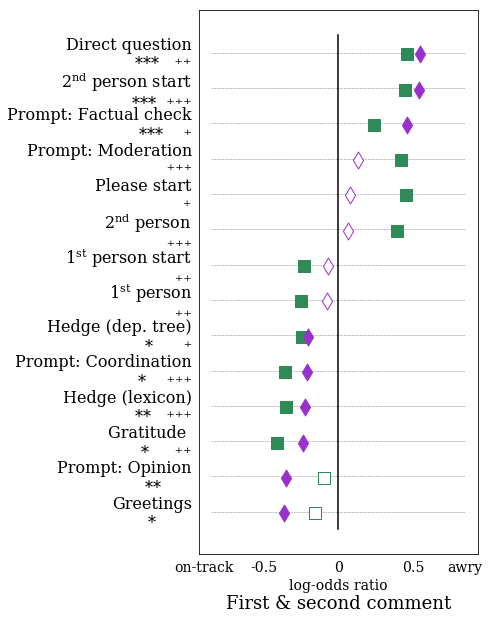

In [31]:
f, ax = plt.subplots(1,1, figsize=(5,10))
_ = draw_figure(ax, first_comparisons, second_comparisons, 'First & second comment')